# Self-Attention Analysis

In [1]:
# based on: https://github.com/naver-ai/cl-vs-mim/blob/main/self_attention_analysis.ipynb
# goated xxxnell as always
import torch


# check gpu env
# print(f"Torch: {torch.__version} \n" + 
print(f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7840b840bfa0> 
Device name: NVIDIA GeForce RTX 4060 Ti


In [2]:

# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -P ~/development/datasets
!gunzip ~/development/datasets/imagenette2-160.tgz -d ~/development/datasets
!tar -xvf ~/development/datasets/imagenette2-160.tar -C ~/development/datasets

gzip: /home/dgcnz/development/datasets/imagenette2-160.tgz: No such file or directory
gzip: /home/dgcnz/development/datasets is a directory -- ignored
imagenette2-160/
imagenette2-160/.DS_Store
imagenette2-160/train/
imagenette2-160/noisy_imagenette.csv
imagenette2-160/val/
imagenette2-160/val/n03394916/
imagenette2-160/val/n03417042/
imagenette2-160/val/n03445777/
imagenette2-160/val/n02102040/
imagenette2-160/val/n03425413/
imagenette2-160/val/n03888257/
imagenette2-160/val/n03028079/
imagenette2-160/val/n03000684/
imagenette2-160/val/n01440764/
imagenette2-160/val/n02979186/
imagenette2-160/val/n02979186/n02979186_7492.JPEG
imagenette2-160/val/n02979186/n02979186_491.JPEG
imagenette2-160/val/n02979186/n02979186_24591.JPEG
imagenette2-160/val/n02979186/n02979186_26451.JPEG
imagenette2-160/val/n02979186/n02979186_11372.JPEG
imagenette2-160/val/n02979186/n02979186_1792.JPEG
imagenette2-160/val/n02979186/n02979186_22111.JPEG
imagenette2-160/val/n02979186/n02979186_18450.JPEG
imagenette2

In [3]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from src.models.components.cl_vs_mim.utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = "~/development/datasets/imagenette2-160"

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=64,
)

## Load the Models

In [4]:
# MoCo
import torch
import src.models.components.cl_vs_mim.moco as moco
from src.models.components.cl_vs_mim.moco  import load_state_dict
from src.models.components.cl_vs_mim.utils import download

#@markdown Execute this cell to download and import MoCo-v3 pre-trained model.

name = "moco_vit_b"  #@param {type:"string"}
path = "../../artifacts/moco_vit_b.pt"  #@param {type:"string"}
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torch/functional.py:540: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4311.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# MoCo
import torch


#@markdown Execute this cell to download and import MoCo-v3 pre-trained model.
name = "part_vit_b"  #@param {type:"string"}
path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584_backbone.ckpt"  #@param {type:"string"}
# url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}
from src.models.components.cl_vs_mim.vit import VisionTransformer
from functools import partial
from torch import nn as nn
# download(url, path, force=False)  # download checkpoints
model = VisionTransformer(  
    patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6))

# model = moco.vit_base()
model = model.cuda()
model = model.eval()


out = model.load_state_dict(torch.load(path), strict=False)
print(out)
model_part = model

_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'head.weight', 'head.bias'], unexpected_keys=[])


In [6]:
import timm
model_mae = timm.create_model('vit_base_patch16_224.mae', pretrained=True)
# dump state dict

model = VisionTransformer(
    patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6)
)
model = model.cuda()
model = model.eval()
out = model.load_state_dict(model_mae.state_dict(), strict=False)
print(out)
model_mae =model



_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


In [7]:
# SimMIM 
import torch
import src.models.components.cl_vs_mim.simmim as simmim
from src.models.components.cl_vs_mim.simmim import load_state_dict

#@markdown Execute this cell to download and import SimMIM pre-trained model.

name = "simmim_vit_b"  #@param {type:"string"}
path = "../../artifacts/simmim_vit_b.pth"  #@param {type:"string"}
model = simmim.vit_base("../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml")
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_simmim = model

=> merge config from ../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml


## Attention Map Visualization

In [8]:
# visualize attns with samples
import matplotlib.pyplot as plt
import ipywidgets as widgets

def mark_token(ax, xs, batch, i, j, color='tab:red'):
    import matplotlib.patches as patches
    from einops import rearrange, reduce, repeat
    from src.models.components.cl_vs_mim.utils import restore
    
    ax.imshow(rearrange(restore(xs.cpu())[batch], 'c h w -> h w c'))
    ax.set_axis_off()

    # create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_attn(ax, attns, batch, i, j, depth, head):
    """
    ax: matplotlib axes
    xs: batch
    batch, i, j: batch coords 
    attns, depth, head: 
    """
    
    attn_list = [list(attn[batch].cpu()) if attn is not None else None for attn in attns]
    attn = torch.stack(attn_list[depth])
    attn = attn[head]  # take head-th head
    attn = attn[1:,1:]  # drop cls token
    attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize

    attn = attn[j * 14 + i]
    attn = attn.reshape([14, 14])

    ax.imshow(attn, cmap="plasma")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()

def update_plot(model_option, depth, batch, coord_x, coord_y, head):
    if model_option == "moco":
        model = model_moco
    elif model_option == "simmim":
        model = model_simmim
    elif model_option == "part":
        model = model_part
    else:
        raise Exception("Invalid option: ", model_option)

    xs, ys = next(iter(dataset_test))
    with torch.no_grad():
        xs = xs.cuda()
        _, _, attns, _ = model(xs)

    fig1, ax1 = plt.subplots(1, 1, figsize=(2, 2), dpi=100)
    mark_token(ax1, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')
    plt.show()

    fig2, ax2 = plt.subplots(1, 1, figsize=(1, 1), dpi=150)
    visualize_attn(ax2, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)
    plt.show()

# Create widgets
model_dropdown = widgets.Dropdown(
    options=['moco', 'simmim', "part"],
    value='moco',
    description='Model:',
)

depth_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=11,
    step=1,
    description='Depth:',
)

batch_slider = widgets.IntSlider(
    value=30,
    min=0,
    max=58,  # Adjust based on your batch size
    description='Batch:',
)

coord_x_slider = widgets.IntSlider(
    value=3,
    min=0,
    max=13,
    description='X coord:',
)

coord_y_slider = widgets.IntSlider(
    value=8,
    min=0,
    max=13,
    description='Y coord:',
)

head_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=11,
    description='Head:',
)

# Create interactive widget
widgets.interactive(
    update_plot,
    model_option=model_dropdown,
    depth=depth_slider,
    batch=batch_slider,
    coord_x=coord_x_slider,
    coord_y=coord_y_slider,
    head=head_slider
)

interactive(children=(Dropdown(description='Model:', options=('moco', 'simmim', 'part'), value='moco'), IntSli…

## Attention Distance

In [9]:
# build off the implementation of https://github.com/sayakpaul/probing-vits
import numpy as np

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j: # zero distance
                continue

            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def calculate_mean_attention_dist(patch_size, attention_weights):
    """ The attention_weights shape = (batch, num_heads, num_patches, num_patches)"""
    
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1) # sum along last axis to get average distance per token
    mean_distances = np.mean(mean_distances, axis=-1) # now average across all the tokens

    return torch.tensor(mean_distances)


#@markdown Execute this cell to calculate attention distance. Attention distance is defined as the average distance between the query tokens and key tokens considering their self-attention weights. Therefore, it conceptually corresponds to the size of the receptive fields in CNNs.
#@markdown 
#@markdown These results shows that the attention distance of CL (MoCo) is significantly higher than that of MIM (SimMIM), especially in the later layers. As seen above, the qualitative visualization, this implies that the representations of CL contain global patterns and shape information, so CL can help ViTs distinguish between objects of images. Conversely, the self-attentions of MIM mainly capture local relationships; i.e., MIM may have difficulty recognizing whole objects and their shapes.

from timm.utils import AverageMeter

model_option = "part"  #@param ["moco", "simmim", "part"]

def update_plot(model_option):
    if model_option == "moco":
        model = model_moco
    elif model_option == "simmim":
        model = model_simmim
    elif model_option == "part":
        model = model_part
    else:
        raise Exception("Invalid option: ", model_option)
        
    encoder_length = len(model.blocks)  # for example 12 for ViT-B
    distances = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        
        with torch.no_grad():
            _, _, attns, _ = model(xs)
            
        for i, attn in enumerate([attn for attn in attns if attn is not None]):    
            attn = attn[:,:,1:,1:]
            attn = attn + 1e-32
            attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
            attn = attn.cpu().float().detach().numpy()

            distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn)
            distances[i].update(torch.mean(distance, dim=0))  # average w.r.t. batch
            
        if idx > -1:
            break
        

    fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
    distances = [torch.mean(distance.avg) for distance in distances]
    ax.plot(range(1, 13), distances, marker="o")
    ax.set_xlabel("Depth")
    ax.set_ylabel("Attention distance (px)")
    ax.set_ylim(top=120, bottom=0)
    plt.show()


# Create widgets
model_dropdown = widgets.Dropdown(
    options=['moco', 'simmim', "part"],
    value='moco',
    description='Model:',
)


# Create interactive widget
widgets.interactive(
    update_plot,
    model_option=model_dropdown,
)

interactive(children=(Dropdown(description='Model:', options=('moco', 'simmim', 'part'), value='moco'), Output…

## Normalized Mutual Information

In [10]:
import torch.nn.functional as F 
from einops import rearrange, reduce, repeat

def calculate_nmi(attn): 
    """ Normalized mutual information with a return type of (batch, head) """
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)
    
    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = - reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = - reduce(pk * torch.log(pk), "b h k -> b h", "sum")
    
    nmiv = mi / torch.sqrt(eq * ek)
    
    return nmiv

#@markdown Execute this cell to calculate the Normalized Mutual Information (NMI). NMI measures the inhomogeneity of self-attentions with respect to queries. In other words, *attention collapse* occurs when the NMI approaches zero.
#@markdown 
#@markdown The results indicate that the mutual information of CL is significantly lower than that of MIM, especially in the later layers. This suggests that the self-attentions of CL tend to collapse into homogeneous distributions.


from timm.utils import AverageMeter


def update_plot(model_option):
    if model_option == "moco":
        model = model_moco
    elif model_option == "simmim":
        model = model_simmim
    elif model_option == "part":
        model = model_part
    else:
        raise Exception("Invalid option: ", model_option)
    encoder_length = len(model.blocks)  # 12 for ViT-B
    nmis = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        
        with torch.no_grad():
            _, _, attns, _ = model(xs)
            
        for i, attn in enumerate([attn for attn in attns if attn is not None]):
            attn = attn[:,:,1:,1:]  # drop cls token
            attn = attn + 1e-8
            attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
            attn = attn.cpu().float()
            
            nmi = calculate_nmi(attn)
            nmis[i].update(torch.mean(nmi, dim=0))  # average w.r.t. batch
            
        if idx > -1:
            break
        
        
    fig, ax = plt.subplots(1, 1, figsize=(4.3, 4), dpi=150)
    nmis = [torch.mean(nmi.avg) for nmi in nmis]
    ax.plot(range(1, 13), nmis, marker="o")
    ax.set_xlabel("Depth")
    ax.set_ylabel("Normalized MI")
    ax.set_ylim(top=0.6, bottom=0.0)
    plt.show()

model_dropdown = widgets.Dropdown(
    options=['moco', 'simmim', "part"],
    value='moco',
    description='Model:',
)

# Create interactive widget
widgets.interactive(
    update_plot,
    model_option=model_dropdown,
)

interactive(children=(Dropdown(description='Model:', options=('moco', 'simmim', 'part'), value='moco'), Output…

<Figure size 640x480 with 0 Axes>

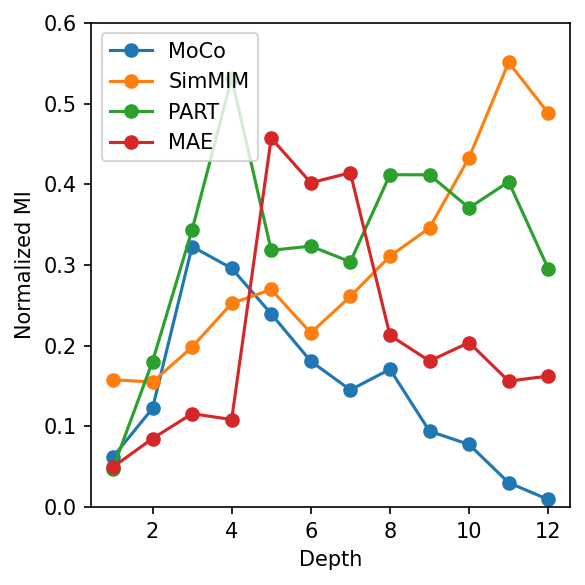

In [11]:
import matplotlib.pyplot as plt
from timm.utils import AverageMeter

def calculate_nmi_for_model(model, dataset_test):
    encoder_length = len(model.blocks)  # 12 for ViT-B
    nmis = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        
        with torch.no_grad():
            _, _, attns, _ = model(xs)
            
        for i, attn in enumerate([attn for attn in attns if attn is not None]):
            attn = attn[:,:,1:,1:]  # drop cls token
            attn = attn + 1e-8
            attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
            attn = attn.cpu().float()
            
            nmi = calculate_nmi(attn)
            nmis[i].update(torch.mean(nmi, dim=0))  # average w.r.t. batch
            
        if idx > -1:
            break
    
    return [torch.mean(nmi.avg) for nmi in nmis]


plt.tight_layout()
plt.show()
# Combine all model data into a list
models = [
    ('MoCo', model_moco),
    ('SimMIM', model_simmim),
    ('PART', model_part),
    ('MAE', model_mae),
]

# Create figure with subplots side by side
fig, ax = plt.subplots(1, figsize=(4, 4), dpi=150)

ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")

# Plot for each model
for i, (name, model) in enumerate(models):
    nmis = calculate_nmi_for_model(model, dataset_test)
    ax.plot(range(1, 13), nmis, marker="o", label=name)
    ax.set_ylim(top=0.6, bottom=0.0)
    # ax.set_title(name)

ax.legend()
plt.tight_layout()
plt.show()

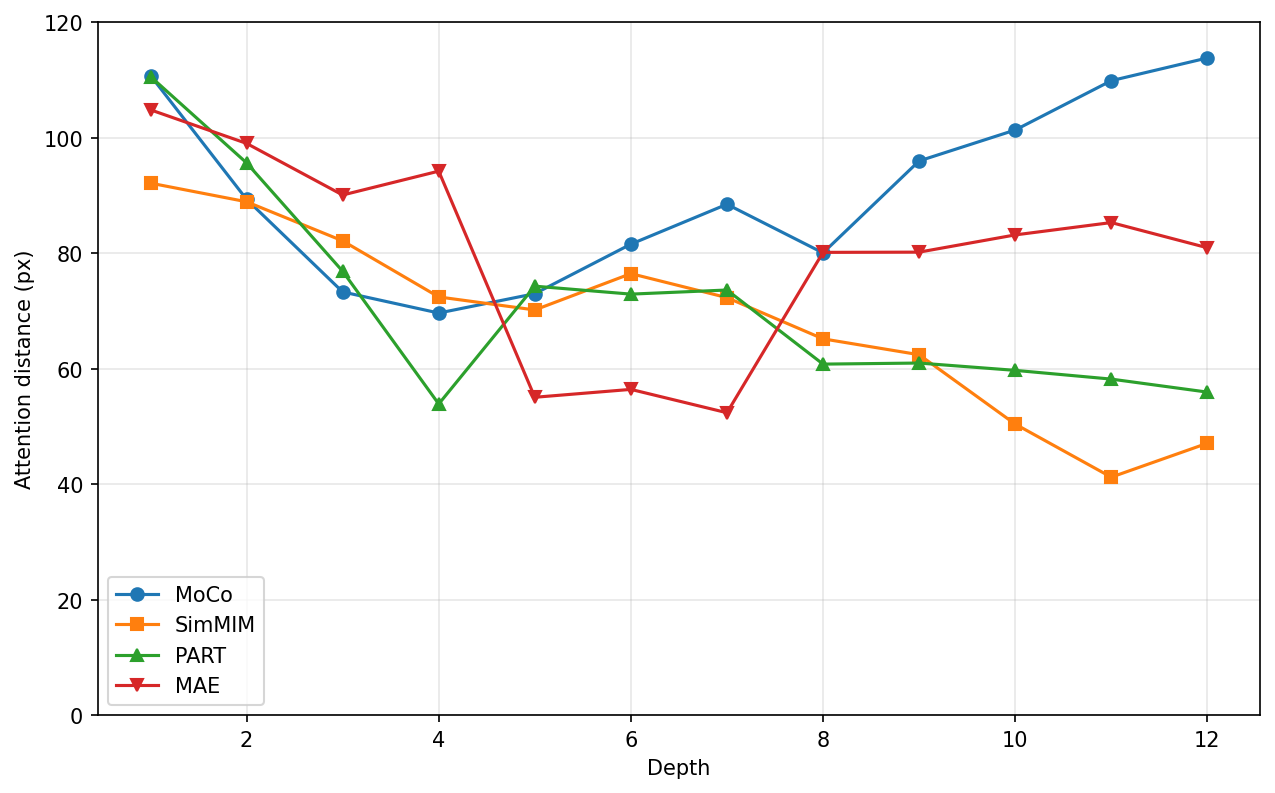

In [12]:
import matplotlib.pyplot as plt

def calculate_distances(model):
    encoder_length = len(model.blocks)
    distances = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        
        with torch.no_grad():
            _, _, attns, _ = model(xs)
            
        for i, attn in enumerate([attn for attn in attns if attn is not None]):    
            attn = attn[:,:,1:,1:]
            attn = attn + 1e-32
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn.cpu().float().detach().numpy()

            distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn)
            distances[i].update(torch.mean(distance, dim=0))
            
        if idx > -1:
            break
    
    return [torch.mean(distance.avg) for distance in distances]

# Calculate distances for all models
moco_distances = calculate_distances(model_moco)
simmim_distances = calculate_distances(model_simmim)
part_distances = calculate_distances(model_part)
mae_distances = calculate_distances(model_mae)

# Plot all curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
x = range(1, 13)

ax.plot(x, moco_distances, marker="o", label="MoCo")
ax.plot(x, simmim_distances, marker="s", label="SimMIM")
ax.plot(x, part_distances, marker="^", label="PART")
ax.plot(x, mae_distances, marker="v", label="MAE")

ax.set_xlabel("Depth")
ax.set_ylabel("Attention distance (px)")
ax.set_ylim(top=120, bottom=0)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()
